# Introduction to Keras

#### Alec Chapman

This tutorial was adapted from [this keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)


The data comes from a [Kaggle competition to classify images as being cats or dogs. The data can be downloaded [here](https://www.kaggle.com/c/dogs-vs-cats/data) after signing into Kaggle (either via a Kaggle account or Google, Facebook, or Yahoo!).

## What is Keras?

Keras is a high-level deep learning API written in Python. Keras uses [TensorFlow](https://www.tensorflow.org/) (Google), [CNTK](https://github.com/Microsoft/cntk) (Microsoft), or [Theano](http://deeplearning.net/software/theano/) (University of Montreal) as a backend.



### Import some modules needed for our tutorial

In [14]:
import glob, os
import random
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import load_model
from skimage.io import imshow
import matplotlib.pyplot as plt

#### Note that I'm using the TensorFlow Backend

This is controlled by an environment variable and is set in
```bash
/home/user/.keras/keras.json
```
which for me has the following content:

```json

    "epsilon": 1e-07,
    "floatx": "float32",
    "image_data_format": "channels_last",
    "backend": "tensorflow"
}
```

### Set the data directory paths

In [2]:
DATADIR = '/srv/DATA/keras_cat_dog/data'
TRAINDIR = os.path.join(DATADIR, 'train')
VALDIR = os.path.join(DATADIR, 'val')

## Overview
In this tutorial we'll build a Convolutional Neural Network to solve the age-old problem: Is it a **dog**, or a **cat**? 

Here's what we'll do today:
- First, we'll look at what it actually means to deal with images in machine learning. 
- Then we'll starting using Keras, a great library that providers a higher-level API to sit on top of TensorFlow. 
- Finally, we'll train our model (for a bit) and then use a pre-trained model to classify a batch of images.

### Working with Images in Python

Convolutional neural networks (CNNs) are often associated with computer vision. They're great at detecting edges, shapes, and higher-level features in images and using those findings to make a decision, such as classifying between cats and dogs. But how do we actually get these images into the neural net?

Basically, images can be seen as arrays of pixels. If we flatten them, it would be one long array of numbers, where each array corresponds to a pixel. CNNs allow us to keep a grid-like shape rather than dealing with flat, 1-dimensional arrays. Specifically, our images will look like this:

   ##### Height x Width x Channels 
where channels corresponds to the color channels (3 for RGB, 1 for grayscale). So a list of images being fed into a neural network will look like this:
   ##### # of images x Height x Width x Channels
   
This array of matrices is often called a *tensor*.
   
Let's look at some examples.

A great library for working with images in Python is the [Python Image Library](https://pillow.readthedocs.io/en/4.2.x/), or **PIL** (actually now **Pillow**, a fork of PIL).


Width, height
(300, 280)


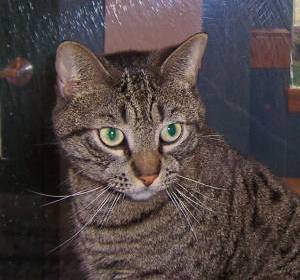

In [3]:
from PIL import Image
example = os.path.join(TRAINDIR, 'cat', 'cat.1.jpg')
img = Image.open(example)
print("Width, height")
print(img.size)
img

That's great for a human. Now let's convert it to something the computer can understand:

In [4]:
arr = np.array(img)
print("Height, width, Channels")
print(arr.shape)
print(arr)

Height, width, Channels
(280, 300, 3)
[[[ 39  44  40]
  [ 39  44  40]
  [ 40  44  43]
  ..., 
  [207 204 173]
  [202 199 166]
  [201 198 163]]

 [[ 40  45  41]
  [ 40  45  41]
  [ 40  44  43]
  ..., 
  [203 200 169]
  [199 196 163]
  [197 194 159]]

 [[ 40  45  41]
  [ 40  45  41]
  [ 40  44  43]
  ..., 
  [199 195 166]
  [199 194 164]
  [199 194 162]]

 ..., 
 [[ 32  30  31]
  [ 30  28  29]
  [ 26  24  25]
  ..., 
  [ 36  23  17]
  [ 41  30  24]
  [ 57  46  40]]

 [[ 32  30  31]
  [ 30  28  29]
  [ 26  24  25]
  ..., 
  [ 42  29  21]
  [ 44  34  25]
  [ 55  45  36]]

 [[ 32  30  31]
  [ 29  27  28]
  [ 25  23  24]
  ..., 
  [ 51  38  30]
  [ 42  32  23]
  [ 40  30  21]]]


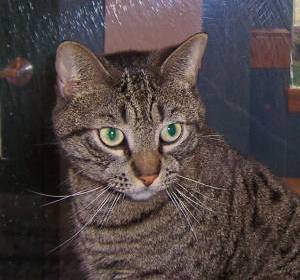

In [5]:
# And back...
example = Image.fromarray(arr)
example

**PIL** offers great utility for working with images. Now let's look at Keras.

### Keras 
[Keras](https://keras.io/) is an API that allows you to work with [TensorFlow](https://www.tensorflow.org/) or [Theano](http://deeplearning.net/software/theano/) in a much more user-friendly way. Per their description:

```
"""
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Use Keras if you need a deep learning library that:

- Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
- Supports both convolutional networks and recurrent networks, as well as combinations of the two.
- Runs seamlessly on CPU and GPU.
"""
```

We'll get to neural nets in a minute. First let's look at some of the image functions Keras offers.

##### Image Generators
It's not always the case you have a bunch of data to train with. One solution to this is called **data augmentation**, where you create alterations of your existing data to provide more examples for your classifier. With images, that means that we'll stretch, augment, and crop the images so that we have a bunch of different versions of each of our images.

Keras also offers a great utility called `flow_from_directory` that will allow us to put images in folders divided by class and Keras will automatically load them, know their label, and convert them into arrays to train/test with

In [6]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        TRAINDIR,  # this is the target directory
        target_size=(227, 227),  # all images will be resized to 227 x 227
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# No distorting for testing!
# Instead, we'll rescale so that pixel values are between 0 and 1
# Which, trust me, is very necessary.
test_datagen = ImageDataGenerator(rescale=1./255) 
validation_generator = test_datagen.flow_from_directory(
        VALDIR,
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [7]:
x_batch, y_batch = next(train_generator)

In [8]:
# This creates 16 images from the images found in TRAINDIR. Let's look at a few of them
print(x_batch.shape)
print(y_batch)

(16, 227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]


(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
(227, 227, 3)
[ 0.  0.  0.  1.  1.  0.  

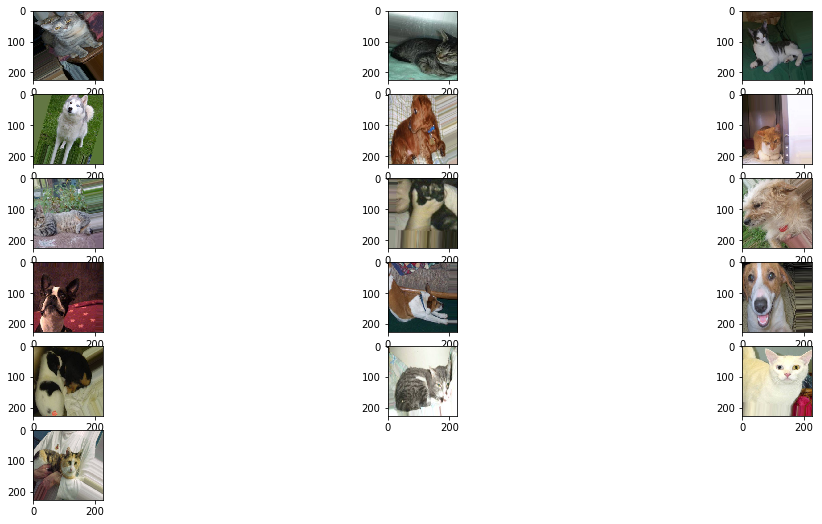

In [26]:
ncols = 3
nimg = x_batch.shape[0]

fig = plt.figure(figsize=(18,9))
for i in range(len(x_batch)):
    x = x_batch[i]
    print(x.shape)
    print(y_batch)
    ax = plt.subplot2grid((nimg//ncols+1, ncols), (i//ncols,i%ncols))
    ax.imshow(x)
    #img = array_to_img(x)
    #img.show()

As you can see, some of these get distorted. While this may look weird to us, it forces the classifier to look for other features that will allow it to recognize cats vs. dogs even with these strange distortions.

Now, let's finally get to our trainer!

### Convolutional Neural Networks
As we covered a few weeks ago, CNNs are special because of what's called a Convolutional Layer. See our presentation for the details.

Here is the architecture that we're going to use, based on Alexnet. It is probably too deep for the problem, and we'll have to look out for overfitting:

In [27]:
model = Sequential()
print("Layer 1")
model.add(Conv2D(
                filters=96,
                kernel_size=11,
                strides=4,
                padding='valid',
                input_shape= \
                    (227, 227, 3),
                data_format='channels_last')
          )
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(
                      pool_size=(3, 3),
                      strides=(2,2),
                      data_format='channels_last')
         )

print("Layer 2")
model.add(Conv2D(256, 5, strides=1, padding='valid', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(
          pool_size=(3, 3),
          strides=(2,2),
           data_format='channels_last')
         )

print("Layer 3")
model.add(Conv2D(
           384, 3,
           strides=1,
           padding='valid',
           data_format='channels_last')
         )
model.add(BatchNormalization())

print("Segment 4")
model.add(Conv2D(
                 256, 3,
                 strides=1,
                 padding='valid',
                 data_format='channels_last')
          )
model.add(BatchNormalization())

print("Segment 5")
model.add(Conv2D(256, 3, strides=1, padding='valid', data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy'])

Layer 1
Layer 2
Layer 3
Segment 4
Segment 5


Now, we're finally ready to train! Let's go.

In [28]:
model.fit_generator(
    train_generator,
    steps_per_epoch=2000 // batch_size, # Number of batches
    epochs=50, # Number of iterations. We're going to keep it small for now.
    validation_data=validation_generator,
    validation_steps=800//batch_size)

#model.save('cnn.h5')

Epoch 1/50
125/125 [==============================] - 214s 2s/step - loss: 2.1668 - acc: 0.5160 - val_loss: 5.1347 - val_acc: 0.4987
Epoch 2/50
125/125 [==============================] - 213s 2s/step - loss: 0.7594 - acc: 0.5285 - val_loss: 0.7579 - val_acc: 0.5773
Epoch 3/50
 64/125 [==============>...............] - ETA: 1:32 - loss: 0.7603 - acc: 0.5244

KeyboardInterrupt: 

In [ ]:
model = load_model('cnn.h5')

In [ ]:
model.evaluate_generator(validation_generator, steps=500//batch_size)

In [ ]:
model.get_config()

In [ ]:
cat = random.choice(glob.glob(os.path.join(VALDIR, 'cat', 'cat*')))
dog = random.choice(glob.glob(os.path.join(VALDIR, 'dog', 'dog*')))
cat = Image.open(cat).resize((227, 227))
dog = Image.open(dog).resize((227, 227))

In [ ]:
cat

In [ ]:
dog

In [ ]:
X = np.array([img_to_array(img) for img in (cat, dog)]).reshape((2, 227, 227, 3))
X.shape

In [ ]:
model.predict(X)

In [ ]:
validation_generator = test_datagen.flow_from_directory(
        VALDIR,
        target_size=(227, 227),
        batch_size=16,
        class_mode='binary')
x, y = next(validation_generator)

In [ ]:
# Loss, accuracy
model.evaluate_generator(validation_generator, steps = 500//16)